# Executive Summary

This project explored two datasets from the Centers of Medicare & Medicaid Services (CMS) on nursing home long-term resident quality of life measures, and penalties issued to nursing homes by CMS and how much the nursing homes were fined. The purpose was to determine the predictive power of quality of life metrics on fine amount and frequency. Multiple learning method and statistical techniques were used to explore these relationships. It was discovered that quality of life measurements do not predict the amount and frequency of fines which nursing homes receive from CMS.

# Introduction

Skilled nursing facilities (SNFs) differ in quality. Ideally, SNFs would all provide care that promotes rehabilitation and/or high quality of life. Sadly, this is not universally the case. Some SNFs receive more and larger penalties from CMS than others, and residents in some SNFs report lower quality of life than residents of other SNFs. This is a problem not just for the residents but for the healthcare system overall: lower quality of life can be tied to increased healthcare spending and greater inefficiency in the healthcare system. 

The purpose of this study is to determine whether there is a relationship between quality of life measurements in long term nursing home residents and whether an SNF will receive a fine from CMS. It is known that factors such as business type, geographic location, and whether an SNF is owned by investors can affect nursing home quality (Harrington, Woolhandler, Mullan, Carrillo, & Himmelstein, 2001), and previous research has identified quality of life as the single largest predictor of early mortality among long-term nursing home residents (Burack, Weiner, Reinhardt, & Annunziato, 2012). There are other correlations between quality of life and other factors proven in the extant literature, such as staffing levels (Castle, 2008), physical restraint (Sullivan‐Marx, Strumpf, Evans, Baumgarten, & Maislin, 1999), and frequency of hospitalizations (Intrator, Zinn, & Mor, 2004). For our purposes, we intend to discover whether fines and quality of life measurements are correlated, and if so how strongly. 

The scope of this project is limited to the ~15,000 SNFs in the United States who accepted Medicare for payment in the year 2018, and who reported quality metrics for that year. As such, the data is all from the year 2018.

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [2]:
import rpy2.rinterface
import rpy2
from rpy2 import robjects
from rpy2.robjects import Formula, Environment
from rpy2.robjects.vectors import IntVector, FloatVector
from rpy2.robjects.lib import grid
from rpy2.robjects.packages import importr, data
from rpy2.rinterface import RRuntimeError
import rpy2.robjects.lib.ggplot2 as ggplot2
from rpy2.robjects import pandas2ri
from rpy2.robjects import r

%load_ext rpy2.ipython

C:\Users\tdrace\AppData\Local\Continuum\anaconda3\envs\main\lib\site-packages\rpy2\robjects\lib\ggplot2.py:67: UserWarning: This was designed againt ggplot2 version 2.2.1 but you have 3.1.1
  warnings.warn('This was designed againt ggplot2 version %s but you have %s' % (TARGET_VERSION, ggplot2.__version__))


In [3]:
df_quality = pd.read_excel('Quality_Measures_-_Long_Stay.xlsx')
df_penalties = pd.read_excel('Penalty_Counts.xlsx')

# Methods

Below are the methods employed. We wrangle our data, explore its dimensions and features, transform and/or impute features as necessary, and then run our learning algorithms. Three main sources were consulted for this section, references for which can be found at the bottom of this notebook: feature engineering (Casari & Zheng, 2018), EDA (McKinney, 2017), and ensemble learning (Vijayalakshmi & Sarkar, 2019).

## Data Wrangling, EDA, and Feature Engineering

In [4]:
df_quality_pivot = df_quality.pivot(index='Federal Provider Number', columns='Measure Description', values='Four Quarter Average Score')

In [5]:
df_quality = pd.merge(df_quality, df_quality_pivot, on='Federal Provider Number')

In [6]:
df_quality = df_quality.drop(['Measure Description', 'Four Quarter Average Score'], axis=1)
df_quality = df_quality.drop_duplicates()

In [7]:
# now, merge quality and penalties
df_quality_penalties = pd.merge(df_quality, df_penalties, on='Federal Provider Number')

In [8]:
df_quality_penalties = df_quality_penalties.drop(['Location_y', 'Provider State_y', 'Provider Name_y', 'ID'], axis=1)

In [12]:
df_quality_penalties.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15527 entries, 0 to 15526
Data columns (total 21 columns):
Federal Provider Number                    15527 non-null object
Provider Name_x                            15527 non-null object
Provider State_x                           15527 non-null object
Location_x                                 15503 non-null object
Percent catheter inserted and left         14999 non-null float64
Percent given pneumococcal vaccine         15019 non-null float64
Percent increased help daily activities    14918 non-null float64
Percent lost too much weight               14982 non-null float64
Percent low-risk residents incontinence    14608 non-null float64
Percent physically restrained              15018 non-null float64
Percent received antianxiety meds          14991 non-null float64
Percent received antipsychotic meds        14988 non-null float64
Percent reported depressive symptoms       15001 non-null float64
Percent reported severe pain         

In [13]:
df_quality_penalties['Total Amount of Fines in Dollars'].describe()

count    1.552700e+04
mean     1.615254e+04
std      5.638674e+04
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      8.125000e+03
max      1.508727e+06
Name: Total Amount of Fines in Dollars, dtype: float64

In [14]:
# we need to add a column that states whether a SNF recieved a fine or not.
def f(row):
    if row['Total Amount of Fines in Dollars'] == 0.00:
        val = 0
    elif row['Total Amount of Fines in Dollars'] > 0.00:
        val = 1
    return val

In [15]:
df_quality_penalties['Fined?'] = df_quality_penalties.apply(f, axis=1)

In [16]:
df_quality_penalties['Fined?'].value_counts()

0    10454
1     5073
Name: Fined?, dtype: int64

## Missing Values Analysis

In [17]:
df_quality_penalties.isnull().sum()

Federal Provider Number                      0
Provider Name_x                              0
Provider State_x                             0
Location_x                                  24
Percent catheter inserted and left         528
Percent given pneumococcal vaccine         508
Percent increased help daily activities    609
Percent lost too much weight               545
Percent low-risk residents incontinence    919
Percent physically restrained              509
Percent received antianxiety meds          536
Percent received antipsychotic meds        539
Percent reported depressive symptoms       526
Percent reported severe pain               634
Percent who fell and seriously injured     508
Percent with UTI                           515
Percent worsened independent mobility      695
Number of Fines                              0
Total Amount of Fines in Dollars             0
Number of Payment Denials                    0
Total Number of Penalties                    0
Fined?       

In [18]:
# ah hah, so we have a number of them.
# let's do some analysis
df_quality_penalties_dropped = df_quality_penalties.dropna()

In [19]:
# Let's see how many rows we lost as a result of dropping them.
num_rows_lost = round(100*(df_quality_penalties.shape[0] - df_quality_penalties_dropped.shape[0])/float(df_quality_penalties.shape[0]))

print("retained {}% of rows".format(num_rows_lost))

retained 6% of rows


Let's perform some more EDA on the dataset and compare the statistics about the data from before and after dropping the missing-values rows:

In [20]:
df_quality_penalties['Fined?'].value_counts(normalize=True)

0    0.673279
1    0.326721
Name: Fined?, dtype: float64

Now, let's look at the same split after we dropped the rows, using the following code:

In [21]:
df_quality_penalties_dropped['Fined?'].value_counts(normalize=True)

0    0.659671
1    0.340329
Name: Fined?, dtype: float64

In [22]:
df_quality_penalties.mean()

Percent catheter inserted and left             2.159872
Percent given pneumococcal vaccine            93.702966
Percent increased help daily activities       14.824133
Percent lost too much weight                   5.629126
Percent low-risk residents incontinence       48.428398
Percent physically restrained                  0.301692
Percent received antianxiety meds             20.717118
Percent received antipsychotic meds           14.622558
Percent reported depressive symptoms           4.557409
Percent reported severe pain                   6.868326
Percent who fell and seriously injured         3.385433
Percent with UTI                               2.832252
Percent worsened independent mobility         17.946425
Number of Fines                                0.476782
Total Amount of Fines in Dollars           16152.536227
Number of Payment Denials                      0.103111
Total Number of Penalties                      0.579893
Fined?                                         0

In [23]:
df_quality_penalties_dropped.mean()

Percent catheter inserted and left             2.119048
Percent given pneumococcal vaccine            93.700141
Percent increased help daily activities       14.854331
Percent lost too much weight                   5.637493
Percent low-risk residents incontinence       48.514545
Percent physically restrained                  0.260618
Percent received antianxiety meds             20.664528
Percent received antipsychotic meds           14.686923
Percent reported depressive symptoms           4.587849
Percent reported severe pain                   6.855744
Percent who fell and seriously injured         3.411168
Percent with UTI                               2.794776
Percent worsened independent mobility         17.955202
Number of Fines                                0.498245
Total Amount of Fines in Dollars           16969.329732
Number of Payment Denials                      0.107892
Total Number of Penalties                      0.606138
Fined?                                         0

To get a better look at how these numbers changed, let's create a new chart that visualizes the percentages changed on average for each column. First, let's create a table of the percent changes in the average values of each column.

In [24]:
(df_quality_penalties_dropped.mean() - df_quality_penalties.mean()) / df_quality_penalties.mean()

Percent catheter inserted and left        -0.018901
Percent given pneumococcal vaccine        -0.000030
Percent increased help daily activities    0.002037
Percent lost too much weight               0.001486
Percent low-risk residents incontinence    0.001779
Percent physically restrained             -0.136146
Percent received antianxiety meds         -0.002538
Percent received antipsychotic meds        0.004402
Percent reported depressive symptoms       0.006679
Percent reported severe pain              -0.001832
Percent who fell and seriously injured     0.007602
Percent with UTI                          -0.013232
Percent worsened independent mobility      0.000489
Number of Fines                            0.045016
Total Amount of Fines in Dollars           0.050568
Number of Payment Denials                  0.046374
Total Number of Penalties                  0.045258
Fined?                                     0.041649
dtype: float64

And now let's visualize these changes as a bar chart, using the following code:

Text(0, 0.5, '% change')

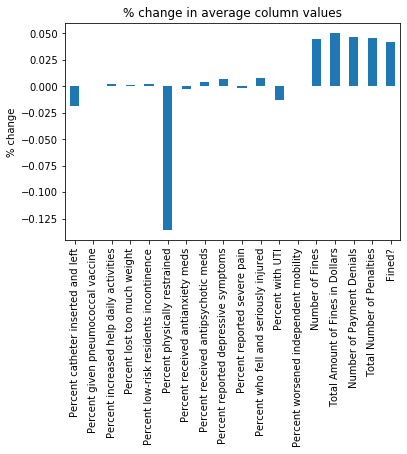

In [25]:
# % change in means as a bar chart
ax = ((df_quality_penalties_dropped.mean() - df_quality_penalties.mean()) / df_quality_penalties.mean()).plot(kind='bar', title='% change in average column values')
ax.set_ylabel('% change')

In [26]:
# we have strings in the data that we need to remove before some of our classifiers
# will work.
# let's specify only numeric columns
df_quality_penalties_dropped = df_quality_penalties_dropped[['Percent catheter inserted and left',
                                            'Percent given pneumococcal vaccine',
                                            'Percent increased help daily activities',
                                            'Percent lost too much weight',
                                            'Percent low-risk residents incontinence',
                                            'Percent physically restrained',
                                            'Percent received antianxiety meds',
                                            'Percent received antipsychotic meds',
                                            'Percent reported depressive symptoms',
                                            'Percent reported severe pain',
                                            'Percent who fell and seriously injured',
                                            'Percent with UTI',
                                            'Percent worsened independent mobility',
                                            'Number of Fines',
                                            'Number of Payment Denials',
                                            'Total Number of Penalties',
                                            'Fined?',
                                            'Total Amount of Fines in Dollars']]

In [27]:
# preliminary machine learning
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

X_dropped = df_quality_penalties_dropped.drop('Fined?', axis=1)
print("learning from {} rows".format(X_dropped.shape[0]))
y_dropped = df_quality_penalties_dropped['Fined?']

knn_params = {'n_neighbors':[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}

knn = KNeighborsClassifier() 

grid = GridSearchCV(knn, knn_params)
grid.fit(X_dropped, y_dropped)

print(grid.best_score_, grid.best_params_)

learning from 14533 rows


C:\Users\tdrace\AppData\Local\Continuum\anaconda3\envs\main\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


1.0 {'n_neighbors': 1}


In [28]:
# alright, 100% accuracy, but the data obviously includes information that clearly demonstrates
# whether a fine was issued or not, such as the amount, and other penalties.
# let's take fine information out for now
df_quality_penalties_dropped1 = df_quality_penalties_dropped[['Percent catheter inserted and left',
                                            'Percent given pneumococcal vaccine',
                                            'Percent increased help daily activities',
                                            'Percent lost too much weight',
                                            'Percent low-risk residents incontinence',
                                            'Percent physically restrained',
                                            'Percent received antianxiety meds',
                                            'Percent received antipsychotic meds',
                                            'Percent reported depressive symptoms',
                                            'Percent reported severe pain',
                                            'Percent who fell and seriously injured',
                                            'Percent with UTI',
                                            'Percent worsened independent mobility',
                                            #'Number of Fines',
                                            'Number of Payment Denials',
                                            #'Total Number of Penalties',
                                            'Fined?']]
                                            #'Total Amount of Fines in Dollars']]


In [29]:
# run it again
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

X_dropped = df_quality_penalties_dropped.drop('Fined?', axis=1)
print("learning from {} rows".format(X_dropped.shape[0]))
y_dropped = df_quality_penalties_dropped['Fined?']

knn_params = {'n_neighbors':[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}

knn = KNeighborsClassifier() 

grid = GridSearchCV(knn, knn_params)
grid.fit(X_dropped, y_dropped)

print(grid.best_score_, grid.best_params_)

learning from 14533 rows


C:\Users\tdrace\AppData\Local\Continuum\anaconda3\envs\main\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


0.6424000550471342 {'n_neighbors': 10}


In [30]:
# alright, well, really no better than null accuracy; actually worse.

## Imputing missing values

In [31]:
# let's start over and try some new things
df_quality_penalties.isnull().sum()

Federal Provider Number                      0
Provider Name_x                              0
Provider State_x                             0
Location_x                                  24
Percent catheter inserted and left         528
Percent given pneumococcal vaccine         508
Percent increased help daily activities    609
Percent lost too much weight               545
Percent low-risk residents incontinence    919
Percent physically restrained              509
Percent received antianxiety meds          536
Percent received antipsychotic meds        539
Percent reported depressive symptoms       526
Percent reported severe pain               634
Percent who fell and seriously injured     508
Percent with UTI                           515
Percent worsened independent mobility      695
Number of Fines                              0
Total Amount of Fines in Dollars             0
Number of Payment Denials                    0
Total Number of Penalties                    0
Fined?       

In [32]:
# we observe missing values in the location column, but we're not concerned 
# with data there, so we'll drop it.
df_quality_penalties.drop('Location_x', axis=1, inplace=True)

In [33]:
df_quality_penalties.isnull().sum()

Federal Provider Number                      0
Provider Name_x                              0
Provider State_x                             0
Percent catheter inserted and left         528
Percent given pneumococcal vaccine         508
Percent increased help daily activities    609
Percent lost too much weight               545
Percent low-risk residents incontinence    919
Percent physically restrained              509
Percent received antianxiety meds          536
Percent received antipsychotic meds        539
Percent reported depressive symptoms       526
Percent reported severe pain               634
Percent who fell and seriously injured     508
Percent with UTI                           515
Percent worsened independent mobility      695
Number of Fines                              0
Total Amount of Fines in Dollars             0
Number of Payment Denials                    0
Total Number of Penalties                    0
Fined?                                       0
dtype: int64

In [34]:
# so, the missing values we have are continuous all continuous

In [35]:
# Category imputer function
from sklearn.base import TransformerMixin
class CustomCategoryImputer(TransformerMixin):
    def __init__(self, cols=None):
        self.cols = cols
        
    def transform(self, df):
        X = df.copy()
        for col in self.cols:
            X[col].fillna(X[col].value_counts().index[0], inplace=True)
        return X
    
    def fit(self, *_):
        return self

In [36]:
# Continuos imputer function
from sklearn.preprocessing import Imputer
class CustomQuantitativeImputer(TransformerMixin):
    def __init__(self, cols=None, strategy='mean'):
        self.cols = cols
        self.strategy = strategy
        
    def transform(self, df):
        X = df.copy()
        impute = Imputer(strategy=self.strategy)
        for col in self.cols:
            X[col] = impute.fit_transform(X[[col]])
        return X
    
    def fit(self, *_):
        return self

In [37]:
df_quality_penalties_colnames_nums = ['Percent catheter inserted and left',
                                            'Percent given pneumococcal vaccine',
                                            'Percent increased help daily activities',
                                            'Percent lost too much weight',
                                            'Percent low-risk residents incontinence',
                                            'Percent physically restrained',
                                            'Percent received antianxiety meds',
                                            'Percent received antipsychotic meds',
                                            'Percent reported depressive symptoms',
                                            'Percent reported severe pain',
                                            'Percent who fell and seriously injured',
                                            'Percent with UTI',
                                            'Percent worsened independent mobility',
                                            'Number of Fines',
                                            'Number of Payment Denials',
                                            'Total Number of Penalties',
                                            'Total Amount of Fines in Dollars',
                                                    'Fined?']

In [38]:
cqi = CustomQuantitativeImputer(cols=df_quality_penalties_colnames_nums, strategy='mean')

In [39]:
df_quality_penalties = cqi.fit_transform(df_quality_penalties)

C:\Users\tdrace\AppData\Local\Continuum\anaconda3\envs\main\lib\site-packages\sklearn\utils\deprecation.py:66: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


In [40]:
df_quality_penalties.isnull().sum()

Federal Provider Number                    0
Provider Name_x                            0
Provider State_x                           0
Percent catheter inserted and left         0
Percent given pneumococcal vaccine         0
Percent increased help daily activities    0
Percent lost too much weight               0
Percent low-risk residents incontinence    0
Percent physically restrained              0
Percent received antianxiety meds          0
Percent received antipsychotic meds        0
Percent reported depressive symptoms       0
Percent reported severe pain               0
Percent who fell and seriously injured     0
Percent with UTI                           0
Percent worsened independent mobility      0
Number of Fines                            0
Total Amount of Fines in Dollars           0
Number of Payment Denials                  0
Total Number of Penalties                  0
Fined?                                     0
dtype: int64

In [41]:
df_quality_penalties = df_quality_penalties.drop('Federal Provider Number', axis=1)
df_quality_penalties = df_quality_penalties.drop('Provider Name_x', axis=1)

In [45]:
%%R -i df_quality_penalties
library(ggplot2)

# Using R to graph values

ggplot(df_quality_penalties, aes(x=Fined?)) + 
    geom_histogram(aes(y=..density..),      # Histogram with density instead of count on y-axis
                   binwidth=1,
                   colour="black", fill="white") +
    geom_density(alpha=.2, fill="#FF6666")  # Overlay with transparent density plot


Error in (function (file = "", n = NULL, text = NULL, prompt = "?", keep.source = getOption("keep.source"),  : 
  <text>:5:42: unexpected ')'
4: 
5: ggplot(df_quality_penalties, aes(x=Fined?)
                                            ^


PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'C:\\Users\\tdrace\\AppData\\Local\\Temp\\tmpaitn0mv6\\Rplots001.png'

## Encoding categorical variables

In [ ]:
df_quality_penalties.info()

In [ ]:
# we definitely want to dummify our Provider State variable
df_quality_penalties = pd.get_dummies(df_quality_penalties, columns=['Provider State_x'], prefix_sep='_')

In [ ]:
# avoiding the dummy variable trap
df_quality_penalties = df_quality_penalties.drop('Provider State_x_AK', axis=1)

In [ ]:
df_quality_penalties.info()

## Z-score standardization

The most common of the normalization techniques, z-score standardization, utilizes a very simple statistical idea of a z-score. The output of a z-score normalization are features that are re-scaled to have a mean of zero and a standard deviation of one. By doing this, by re-scaling our features to have a uniform mean and variance (square of standard deviation), then we allow models such as KNN to learn optimally and not skew towards larger scaled features. 

In [44]:
# built in z-score normalizer
from sklearn.preprocessing import StandardScaler

In [46]:
df_quality_penalties.iloc[:,0:72]

,Percent catheter inserted and left,Percent given pneumococcal vaccine,Percent increased help daily activities,Percent lost too much weight,Percent low-risk residents incontinence,Percent physically restrained,Percent received antianxiety meds,Percent received antipsychotic meds,Percent reported depressive symptoms,Percent reported severe pain,...,Provider State_x_SD,Provider State_x_TN,Provider State_x_TX,Provider State_x_UT,Provider State_x_VA,Provider State_x_VT,Provider State_x_WA,Provider State_x_WI,Provider State_x_WV,Provider State_x_WY
0,0.913644,100.000000,17.829460,2.985073,59.999998,0.000000,0.000000,8.053695,5.479451,4.506574,...,0,0,0,0,0,0,0,0,0,0
1,0.441907,99.692307,7.911391,2.215188,13.567842,0.000000,43.478262,41.711229,3.333331,6.306453,...,0,0,0,0,0,0,0,0,0,0
2,6.763294,99.201598,13.397130,5.165292,22.784808,2.594810,8.606557,5.934066,0.000000,1.668085,...,0,0,0,0,0,0,0,0,0,0
3,0.308351,99.943758,5.321354,3.344671,33.207545,0.056243,5.905512,6.722689,2.531644,0.000000,...,0,0,0,0,0,0,0,0,0,0
4,0.000000,98.623856,15.060243,5.882350,23.728815,0.917432,16.184971,5.339806,0.000000,0.801631,...,0,0,0,0,0,0,0,0,0,0
5,0.784689,98.200514,10.967744,5.438069,75.460121,0.257069,7.598786,8.000000,15.384617,5.986839,...,0,0,0,0,0,0,0,0,0,0
6,4.799205,100.000000,11.111111,3.409093,79.617837,0.000000,21.751413,15.873019,11.232877,1.279296,...,0,0,0,0,0,0,0,0,0,0
7,1.160228,100.000000,6.958764,7.191010,64.210525,0.000000,10.044642,0.224215,0.476192,4.613149,...,0,0,0,0,0,0,0,0,0,0
8,0.000000,98.170735,13.013700,2.758620,67.532468,0.000000,20.547945,31.250000,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
9,2.339582,94.493394,16.500000,4.830917,55.882355,0.000000,6.053267,9.213482,3.636362,8.817152,...,0,0,0,0,0,0,0,0,0,0


In [47]:
# this is really clutch
df_quality_penalties_colnames = df_quality_penalties.columns.values.tolist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000000010A585C0>,
      dtype=object)

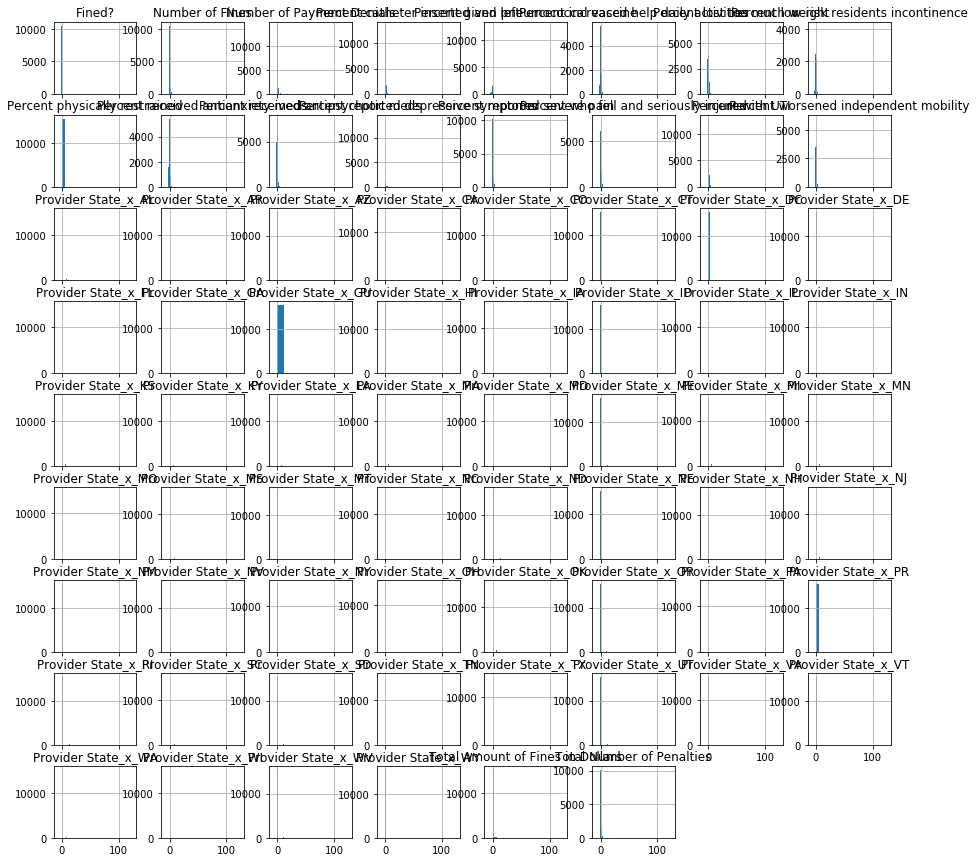

In [48]:
scale = StandardScaler() # instantiate a z-scaler object

df_quality_penalties_scaled = pd.DataFrame(scale.fit_transform(df_quality_penalties), columns=df_quality_penalties_colnames)
df_quality_penalties_scaled.hist(figsize=(15, 15), sharex=True)

## Bucketing continuous features and Evaluation

In [49]:
class CustomCutter(TransformerMixin):
    def __init__(self, col, bins, labels=False):
        self.labels = labels
        self.bins = bins
        self.col = col
        
    def transform(self, df):
        X = df.copy()
        X[self.col] = pd.cut(X[self.col], bins=self.bins, labels=self.labels)
        return X
    
    def fit(self, *_):
        return self

In [50]:
# so we'll bucket our fine amounts variable since that has the greatest stratification
cc = CustomCutter(col='Total Amount of Fines in Dollars', bins=10)
df_quality_penalties = cc.fit_transform(df_quality_penalties)

In [51]:
df_quality_penalties['Total Amount of Fines in Dollars'].describe()

count    15527.00000
mean         0.03729
std          0.29590
min          0.00000
25%          0.00000
50%          0.00000
75%          0.00000
max          9.00000
Name: Total Amount of Fines in Dollars, dtype: float64

In [52]:
# we can see from how 10 bins buckets our fine amounts that most fines are small,
# and that the largest fines are orders of magnitude larger than the majority.

We can also view the correlation matrix plot for the numerical variables.

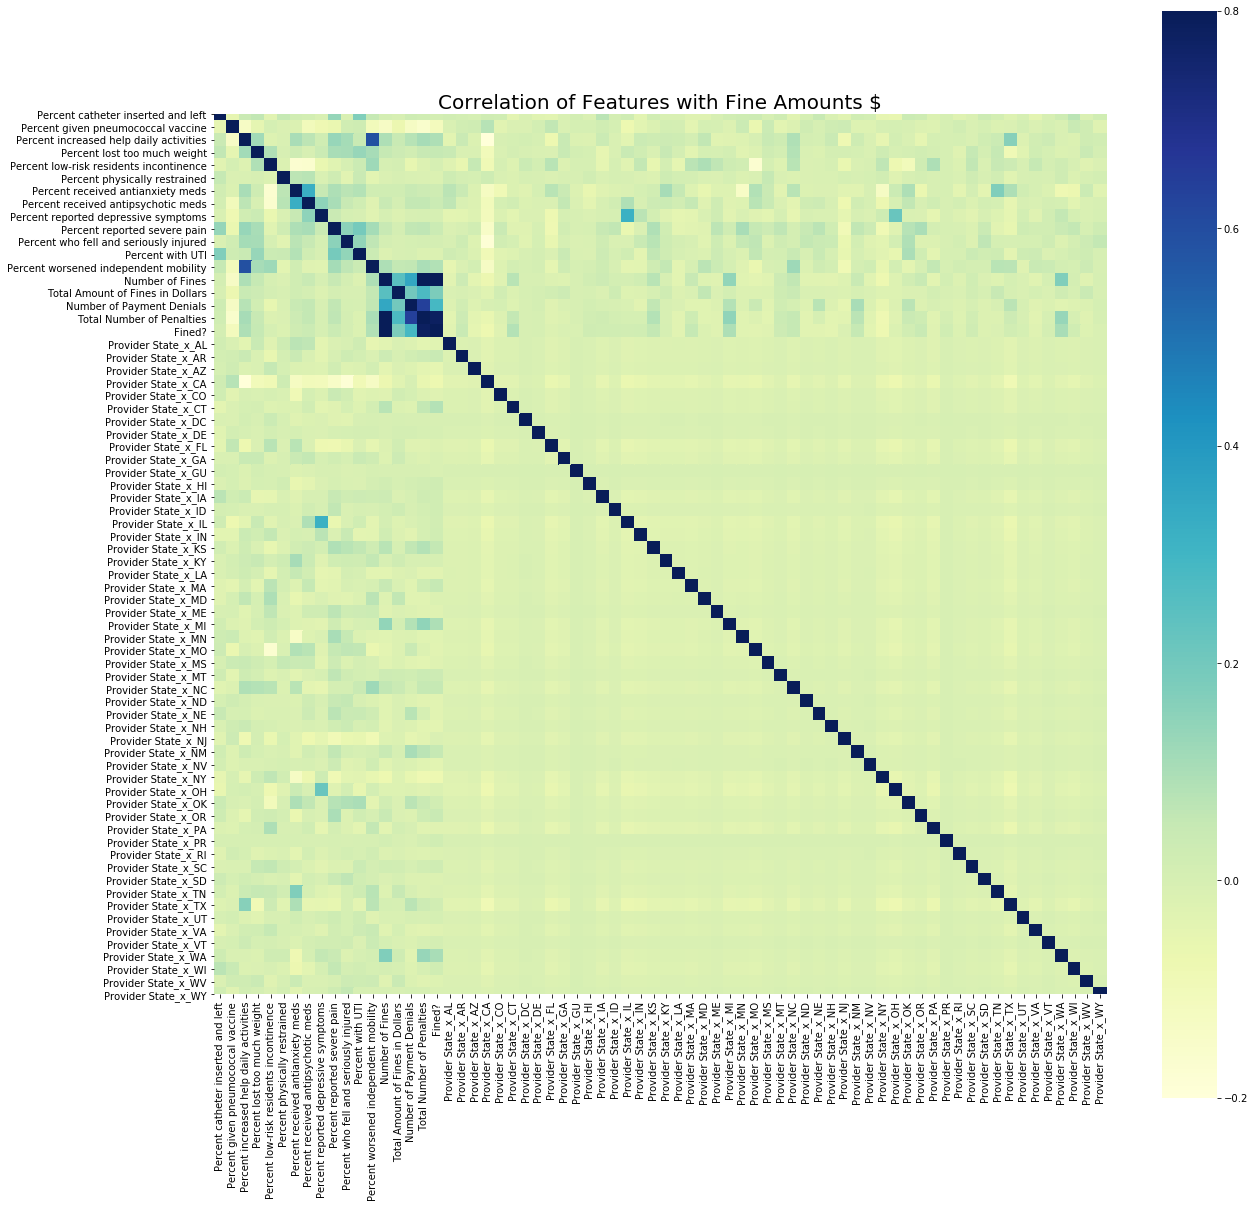

In [57]:
# Get correlation of numerical variables
df_numerical_features= df_quality_penalties.select_dtypes(include=[np.number])

correlation= df_numerical_features.corr()
correlation["Total Amount of Fines in Dollars"].sort_values(ascending=False)*100
# Correlation Heat Map (Seaborn library)
f, ax= plt.subplots(figsize=(20,20))
plt.title("Correlation of Features with Fine Amounts $", y=1, size=20)

# cmap - matplotlib colormap name or object - can be used to set the color options
# vmin and vmax is used to anchor the colormap
sns.heatmap(correlation, square= True, vmin=-0.2, vmax=0.8, cmap="YlGnBu")

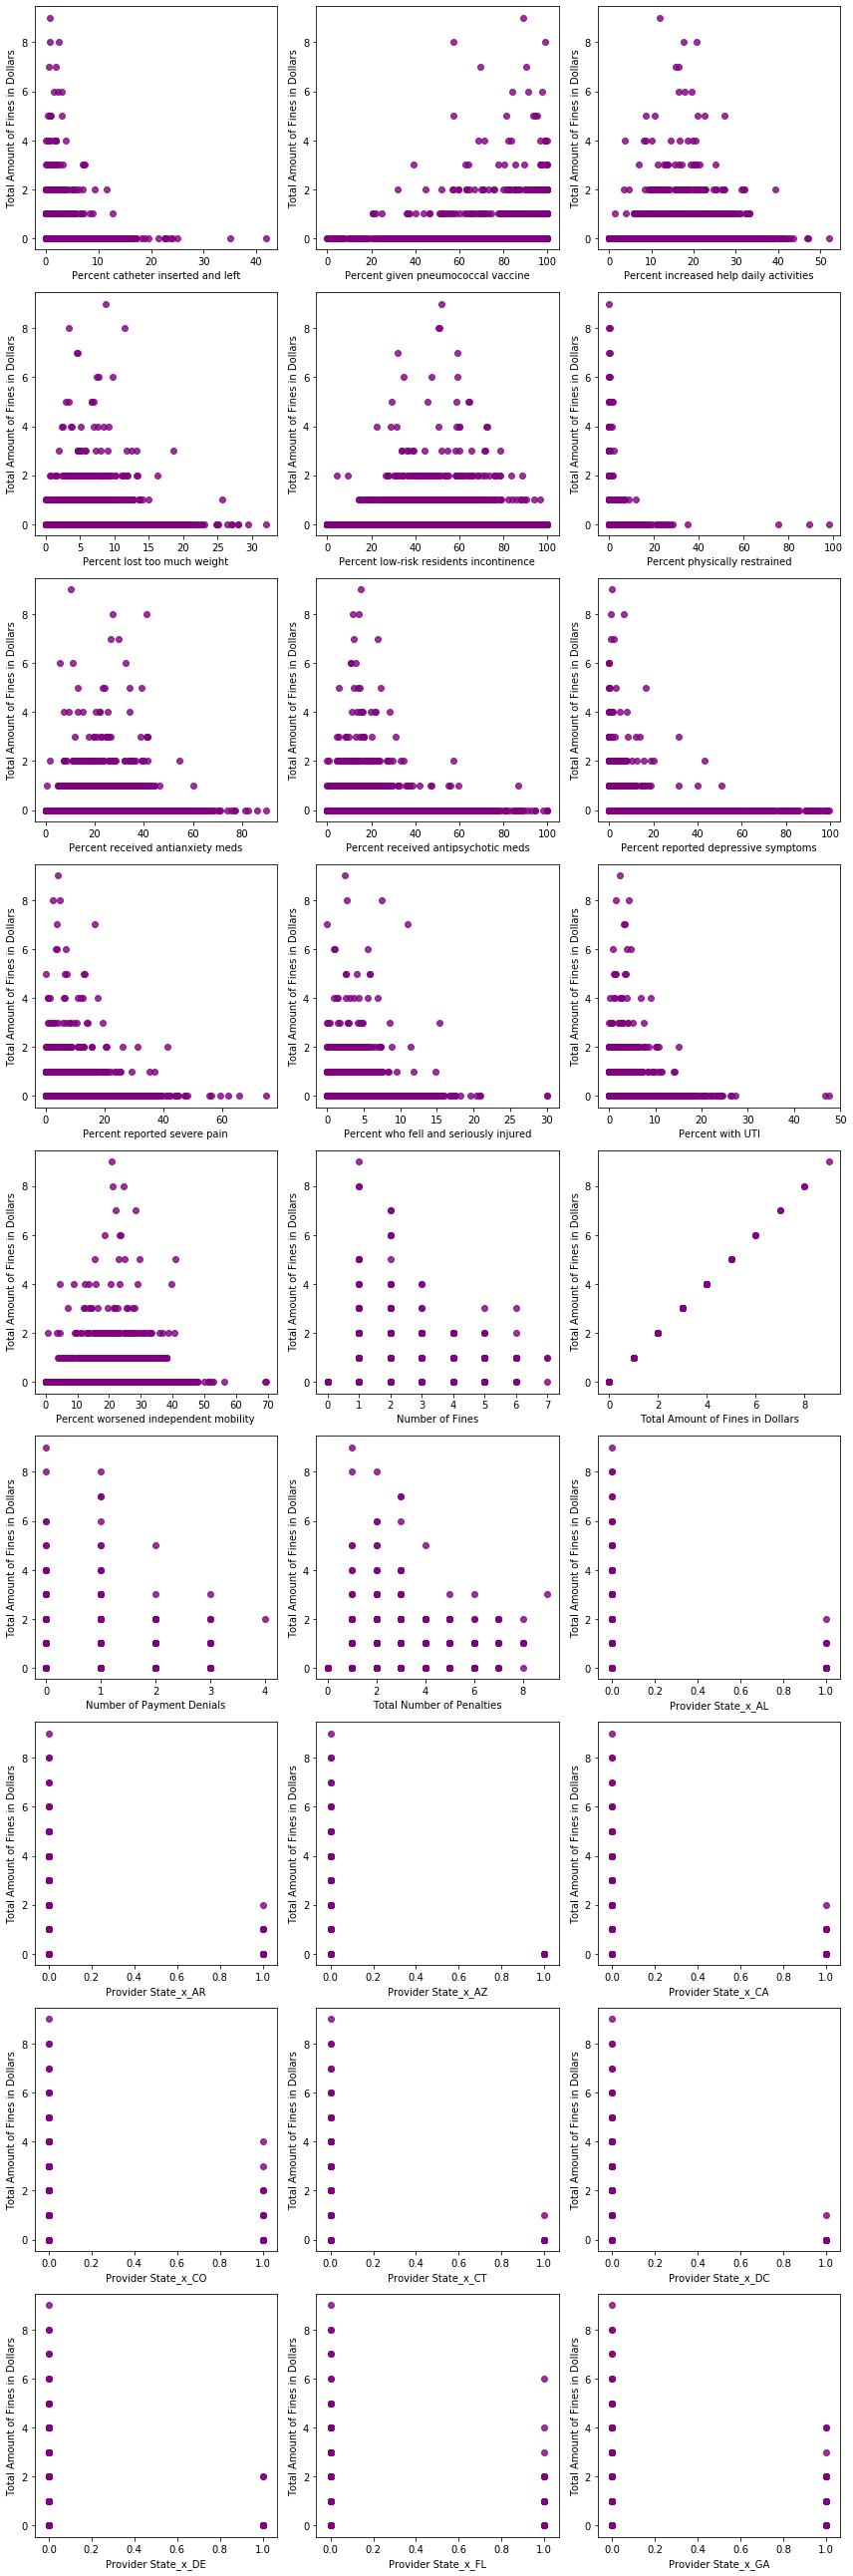

In [58]:
# We can evaluate the correlation of the numerical variables with Total Amount in Fines 
# to see how these numerical variables are related to the fine amounts:

row_count = 9
col_count = 3

fig, axs = plt.subplots(row_count, col_count, figsize=(12,36))
exclude_columns = ['Fined?']
plot_numeric_features = [col for col in numerical_features if col not in exclude_columns]

for eachrow in range(0, row_count):
    for eachcol in range(0, col_count): 
        i = eachrow*col_count + eachcol
        if i < len(plot_numeric_features):
            sns.regplot(df_quality_penalties[plot_numeric_features[i]], df_quality_penalties['Total Amount of Fines in Dollars'], \
                ax = axs[eachrow][eachcol], color='purple', fit_reg=False)

# tight_layout automatically adjusts subplot params so that the subplot(s) fits in to the figure area 
plt.tight_layout() 
plt.show()

In [59]:
# ordinal data
total_penalties = df_quality_penalties['Total Number of Penalties']
total_penalties.describe()

count    15527.000000
mean         0.579893
std          1.008997
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          9.000000
Name: Total Number of Penalties, dtype: float64

In [60]:
total_penalties = total_penalties.astype(str)
total_penalties.describe()

count     15527
unique       10
top         0.0
freq      10149
Name: Total Number of Penalties, dtype: object

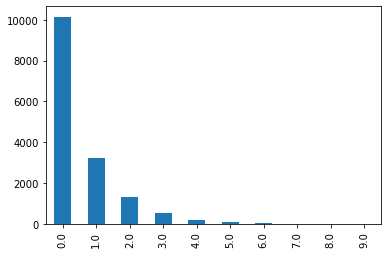

In [61]:
total_penalties.value_counts().plot(kind='bar')

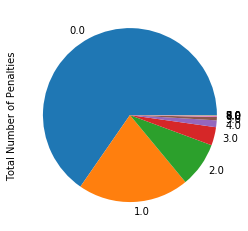

In [62]:
total_penalties.value_counts().plot(kind='pie')

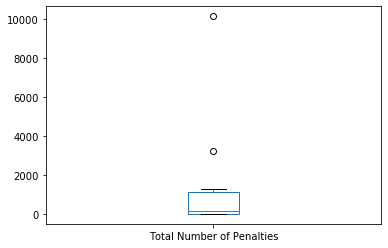

In [63]:
total_penalties.value_counts().plot(kind='box')

Text(0.5, 1.0, 'Total Amount of Fines in $ by Number of Penalties')

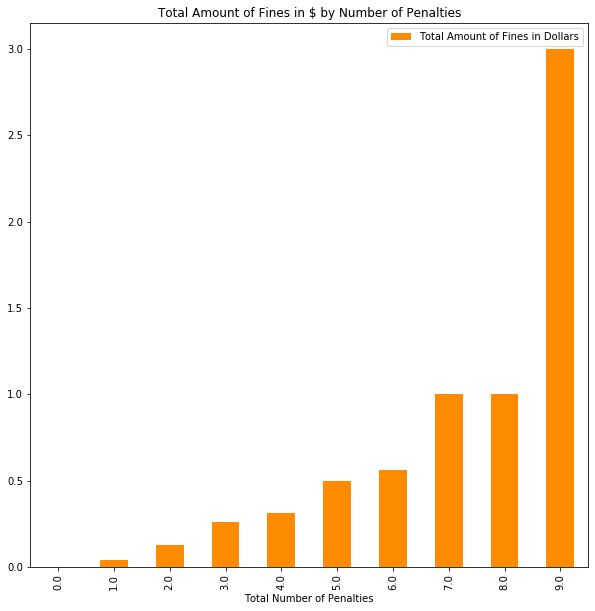

In [64]:
# ratio data
fig = plt.figure(figsize=(10,10))
ax = fig.gca()

df_quality_penalties.groupby('Total Number of Penalties')[['Total Amount of Fines in Dollars']].mean().plot.bar(stacked=False, ax=ax, color='darkorange')
ax.set_title('Total Amount of Fines in $ by Number of Penalties')

In [65]:
# null accuracy
df_quality_penalties['Fined?'].value_counts(normalize=True)

0.0    0.673279
1.0    0.326721
Name: Fined?, dtype: float64

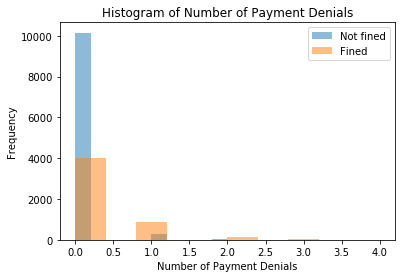

In [66]:
# visualizing differences between those SNFs that were fined vs those that were not fined
col = 'Number of Payment Denials'
plt.hist(df_quality_penalties[df_quality_penalties['Fined?']==0][col], 10, alpha=0.5, label='Not fined')
plt.hist(df_quality_penalties[df_quality_penalties['Fined?']==1][col], 10, alpha=0.5, label='Fined')
plt.legend(loc='upper right')
plt.xlabel(col)
plt.ylabel('Frequency')
plt.title('Histogram of {}'.format(col))
plt.show()

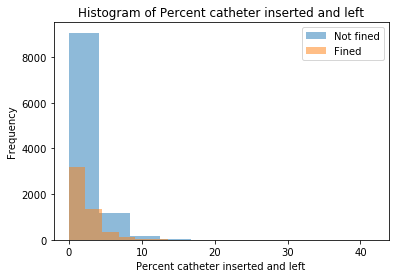

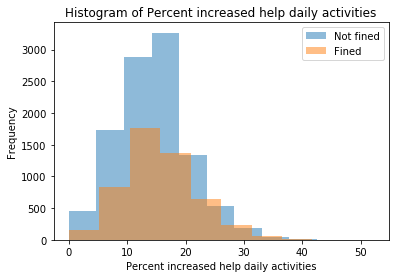

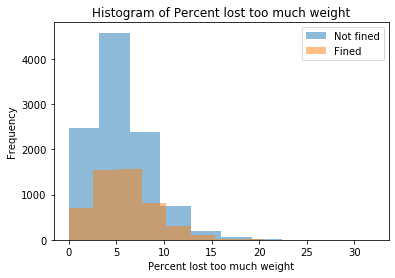

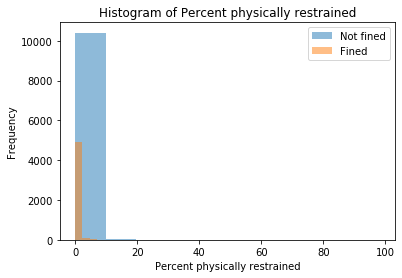

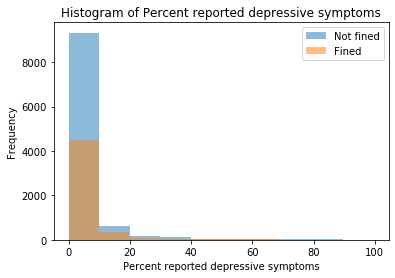

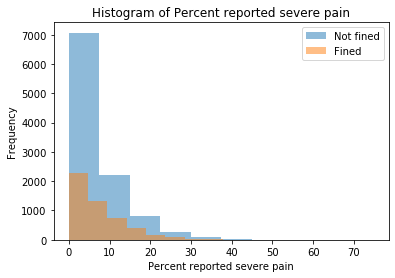

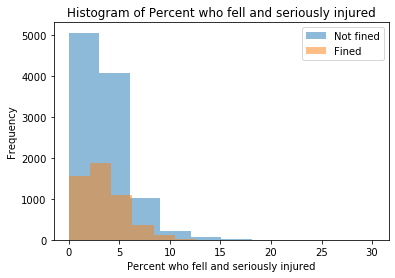

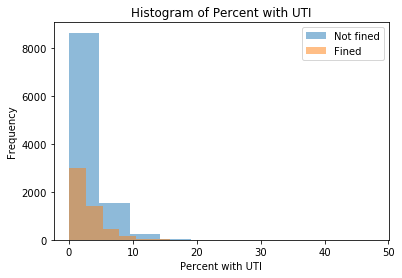

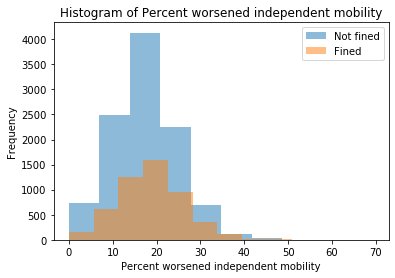

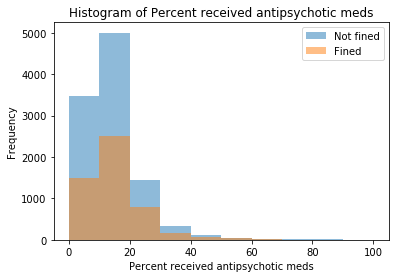

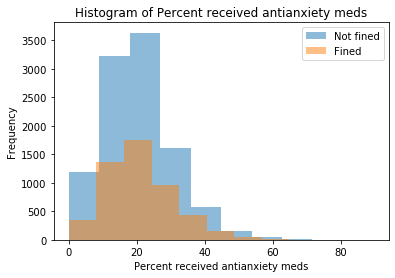

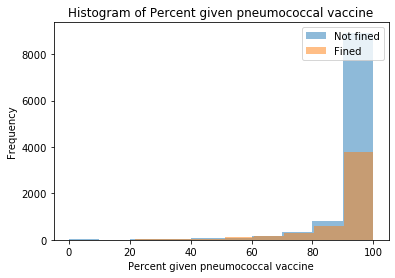

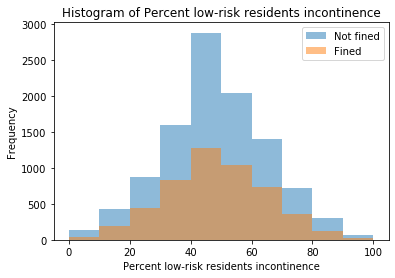

In [67]:
# let's try multiple columns
for col in quality_measures:
    plt.hist(df_quality_penalties[df_quality_penalties['Fined?']==0][col], 10, alpha=0.5, label='Not fined')
    plt.hist(df_quality_penalties[df_quality_penalties['Fined?']==1][col], 10, alpha=0.5, label='Fined')
    plt.legend(loc='upper right')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.title('Histogram of {}'.format(col))
    plt.show()

In [68]:
# Quality of life measures seem to not have any kind of relationship to whether a SNF received a fine
# seems to be confirmed by low correlation; in fact, some are negatively correlated

corr = df_quality_penalties.corr()["Total Amount of Fines in Dollars"]

# Sort the correlation values. 
# Use [::-1] to sort it in descending manner
# Use [::+1] to sort it in ascending manner
corr[np.argsort(corr)[::-1]]

Total Amount of Fines in Dollars           1.000000
Total Number of Penalties                  0.278340
Number of Fines                            0.252532
Number of Payment Denials                  0.200924
Fined?                                     0.180912
Provider State_x_MD                        0.059198
Percent worsened independent mobility      0.055676
Provider State_x_TN                        0.049662
Percent increased help daily activities    0.042277
Provider State_x_WV                        0.040046
Provider State_x_NC                        0.038514
Percent lost too much weight               0.031282
Provider State_x_GA                        0.031206
Provider State_x_MT                        0.029521
Provider State_x_ID                        0.027131
Provider State_x_WA                        0.024434
Provider State_x_KY                        0.023305
Percent received antianxiety meds          0.022386
Provider State_x_FL                        0.015877
Provider Sta

So, obviously some states are associated with higher fine amounts than others, but it's only a slight correlation.

## Max Voting

In max-voting, each base model makes a prediction and votes for each sample. Only the sample class with the highest votes is included in the final predictive class.

In [69]:
df_quality_penalties.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15527 entries, 0 to 15526
Data columns (total 70 columns):
Percent catheter inserted and left         15527 non-null float64
Percent given pneumococcal vaccine         15527 non-null float64
Percent increased help daily activities    15527 non-null float64
Percent lost too much weight               15527 non-null float64
Percent low-risk residents incontinence    15527 non-null float64
Percent physically restrained              15527 non-null float64
Percent received antianxiety meds          15527 non-null float64
Percent received antipsychotic meds        15527 non-null float64
Percent reported depressive symptoms       15527 non-null float64
Percent reported severe pain               15527 non-null float64
Percent who fell and seriously injured     15527 non-null float64
Percent with UTI                           15527 non-null float64
Percent worsened independent mobility      15527 non-null float64
Number of Fines                  

In [70]:
# need to do some feature engineering real fast...
df_quality_penalties_drop = df_quality_penalties.drop(['Total Amount of Fines in Dollars', 'Number of Fines'], axis=1)

In [71]:
# create feature & response sets
# feature_columns = quality_measures
X = df_quality_penalties_drop.drop('Fined?', axis=1)
Y = df_quality_penalties_drop['Fined?']

# Create train & test sets
X_train, X_test, Y_train, Y_test = \
train_test_split(X, Y, test_size=0.20, random_state=1)

In [72]:
# We build our models with the decision tree, SVM, and logistic regression algorithms:

# create the sub models
estimators = []

dt_model = DecisionTreeClassifier(random_state=1)
estimators.append(('DecisionTree', dt_model))

svm_model = SVC(random_state=1)
estimators.append(('SupportVector', svm_model))

logit_model = LogisticRegression(random_state=1)
estimators.append(('Logistic Regression', logit_model))

In [73]:
# We build individual models with each of the classifiers we've chosen. We can 
# then see the accuracy score of each of the individual base learners:

for each_estimator in (dt_model, svm_model, logit_model):
    each_estimator.fit(X_train, Y_train)
    Y_pred = each_estimator.predict(X_test)
    print(each_estimator.__class__.__name__, accuracy_score(Y_test, Y_pred))

DecisionTreeClassifier 1.0


C:\Users\tdrace\AppData\Local\Continuum\anaconda3\envs\main\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC 0.7566001287830006
LogisticRegression 1.0


C:\Users\tdrace\AppData\Local\Continuum\anaconda3\envs\main\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [74]:
# We proceed to ensemble our models and use VotingClassifier to score the accuracy of 
# the ensemble model:

# Using VotingClassifier() to build ensemble model with Hard Voting
ensemble_model = VotingClassifier(estimators=estimators, voting='hard')

ensemble_model.fit(X_train,Y_train)
predicted_labels = ensemble_model.predict(X_test) 

print("Classifier Accuracy using Hard Voting: ", accuracy_score(Y_test, predicted_labels))

C:\Users\tdrace\AppData\Local\Continuum\anaconda3\envs\main\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\tdrace\AppData\Local\Continuum\anaconda3\envs\main\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classifier Accuracy using Hard Voting:  1.0


## Averaging

Averaging is usually used for regression problems or can be used while estimating the probabilities in classification tasks. Predictions are extracted from multiple models and an average of the predictions are used to make the final prediction. 

In [75]:
# Import required libraries
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR

In [76]:
# Create feature and response variable set
from sklearn.model_selection import train_test_split

# create feature & response variables
X = df_quality_penalties_drop.drop('Fined?', axis=1)
Y = df_quality_penalties_drop['Fined?']

# Create train & test sets
X_train, X_test, Y_train, Y_test = \
train_test_split(X, Y, test_size=0.20, random_state=1)

In [77]:
# Build the base regression learners using linear regression, SVR, and a decision tree:
# Build base learners
linreg_model = LinearRegression()
svr_model = SVR()
regressiontree_model = DecisionTreeRegressor()

# Fitting the model
linreg_model.fit(X_train, Y_train)
svr_model.fit(X_train, Y_train)
regressiontree_model.fit(X_train, Y_train)

C:\Users\tdrace\AppData\Local\Continuum\anaconda3\envs\main\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

In [78]:
# Use the base learners to make a prediction based on the test data:
linreg_predictions = linreg_model.predict(X_test)
svr_predictions = svr_model.predict(X_test)
regtree_predictions = regressiontree_model.predict(X_test)

In [79]:
# We divide the summation of the predictions by 3 i.e. number of base learners 
average_predictions=(linreg_predictions + svr_predictions + regtree_predictions)/3

In [80]:
average_predictions

array([0.82013126, 0.16745472, 0.21828052, ..., 0.92029012, 0.6705577 ,
       0.85281941])

## Weighted averaging

Like averaging, weighted averaging is also used for regression tasks. Alternatively, it can be used while estimating probabilities in classification problems. Base learners are assigned different weights, which represent the importance of each model in the prediction.

In [81]:
# Import required libraries
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

In [82]:
# Create feature and response variable set
# We create train & test sample from our dataset
from sklearn.model_selection import train_test_split

# create feature & response variables
X = df_quality_penalties_drop.drop('Fined?', axis=1)
Y = df_quality_penalties_drop['Fined?']

# Create train & test sets
X_train, X_test, Y_train, Y_test = \
train_test_split(X, Y, test_size=0.20, random_state=1)

In [83]:
# create the sub models
estimators = []

dt_model = DecisionTreeClassifier()
estimators.append(('DecisionTree', dt_model))

svm_model = SVC(probability=True)
estimators.append(('SupportVector', svm_model))

logit_model = LogisticRegression()
estimators.append(('Logistic Regression', logit_model))

In [84]:
# Fit the models on the test data:
dt_model.fit(X_train, Y_train)
svm_model.fit(X_train, Y_train)
logit_model.fit(X_train, Y_train)

C:\Users\tdrace\AppData\Local\Continuum\anaconda3\envs\main\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\tdrace\AppData\Local\Continuum\anaconda3\envs\main\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [85]:
# Use the predict_proba() function to predict the class probabilities:
dt_predictions = dt_model.predict_proba(X_test)
svm_predictions = svm_model.predict_proba(X_test)
logit_predictions = logit_model.predict_proba(X_test)

In [86]:
# Assign different weights to each of the models to get our final predictions:
weighted_average_predictions=(dt_predictions * 0.3 + svm_predictions * 0.4 + logit_predictions * 0.3)

In [87]:
weighted_average_predictions

array([[0.01606217, 0.98393783],
       [0.84728728, 0.15271272],
       [0.76701703, 0.23298297],
       ...,
       [0.04391945, 0.95608055],
       [0.05667553, 0.94332447],
       [0.1832888 , 0.8167112 ]])

## k-fold and leave-one-out cross-validation

k-fold CV is a widely used approach that's used for estimating test errors. The original dataset with N observations is divided into K subsets and the holdout method is repeated K times. In each iteration, K-1 subsets are used as the training set and the rest are used as the testing set.

In [88]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import KFold 

In [89]:
# So here, we'll run Total Amount of Fine as the response variable and quality metrics as features
df_quality_penalties_drop1 = df_quality_penalties.drop(['Fined?', 'Number of Fines'], axis=1)

In [90]:
# create feature & response variables
X = df_quality_penalties_drop1.drop('Total Amount of Fines in Dollars', axis=1)
Y = df_quality_penalties_drop1['Total Amount of Fines in Dollars']
X=np.array(X)
Y=np.array(Y)

In [91]:
# We'll split the dataset into K consecutive folds (without shuffling by default) with K=10:
kfoldcv = KFold(n_splits=10)
kf_ytests = []
kf_predictedvalues = []
mean_mse = 0.0

for train_index, test_index in kfoldcv.split(X):
    X_train, X_test = X[train_index], X[test_index] 
    Y_train, Y_test = Y[train_index], Y[test_index]
    
    model = LinearRegression()
    model.fit(X_train, Y_train) 
    Y_pred = model.predict(X_test)
        
    # there is only one y-test and y-pred per iteration over the kfoldcv.split, 
    # so we append them to the respective lists.
        
    kf_ytests += list(Y_test)
    kf_predictedvalues += list(Y_pred)
    mse = mean_squared_error(kf_ytests, kf_predictedvalues)
    r2score = r2_score(kf_ytests, kf_predictedvalues)
    print("R^2: {:.2f}, MSE: {:.2f}".format(r2score, mse))
    mean_mse += mse   

R^2: 0.07, MSE: 0.15
R^2: 0.08, MSE: 0.12
R^2: 0.07, MSE: 0.12
R^2: 0.07, MSE: 0.10
R^2: 0.08, MSE: 0.09
R^2: 0.08, MSE: 0.09
R^2: 0.09, MSE: 0.09
R^2: 0.09, MSE: 0.08
R^2: 0.09, MSE: 0.08
R^2: 0.09, MSE: 0.08


In [92]:
# We can look at our coefficient of determination using r2_score() and the mean squared error using mse():
print("Average CV Score :" ,mean_mse/10) 

Average CV Score : 0.10095310385229059


Text(0, 0.5, 'Predicted fine')

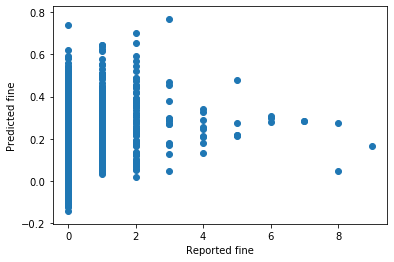

In [93]:
# Let us plot the model
plt.scatter(kf_ytests, kf_predictedvalues)
plt.xlabel('Reported fine')
plt.ylabel('Predicted fine')

## Bootstrapping

Bootstrapping is a non-parametric resampling technique that's used to assess the uncertainty in the estimator. In bootstrapping, a large number of samples with the same size are drawn repeatedly from an original sample. This allows a given observation to be included in more than one sample, which is known as sampling with replacement. In the bootstrap method, n samples are created from the original data by sampling with replacement. Each sample is of identical size. The larger n, the closer the set of samples will be to the ideal bootstrap sample.

In [94]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

from sklearn.utils import resample

In [95]:
# The create_bootstrap_oob( ) custom function takes a DataFrame as an input 
# parameter and creates both bootstrap and Out-Of-the-Bag (OOB) samples.
def create_bootstrap_oob(df):
    global df_OOB
    global df_bootstrap_sample 
    
    # creating the bootstrap sample
    df_bootstrap_sample = resample(df, replace=True, n_samples=100)
    
    # creating the OOB sample 
    bootstrap_sample_index = tuple(df_bootstrap_sample.index)
    bootstrap_df = df.index.isin(bootstrap_sample_index)
    df_OOB = df[~bootstrap_df]

In [96]:
iteration=50
bootstap_statistics=list()
originalsample_statistics=list()

for i in range(iteration):
    # Call custom function create_bootstrap_oob(). Pass df
    create_bootstrap_oob(df_quality_penalties)
    
    # Capture mean value of mpg variable for all bootstrap samples
    bootstap_statistics.append(df_bootstrap_sample['Total Amount of Fines in Dollars'].mean())
    
    originalsample_statistics.append(df_quality_penalties['Total Amount of Fines in Dollars'].mean())

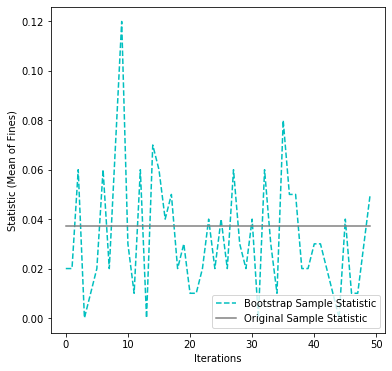

In [97]:
f, ax= plt.subplots(figsize=(6,6))

plt.plot(bootstap_statistics, 'c--', label='Bootstrap Sample Statistic')
plt.plot(originalsample_statistics, 'grey', label='Original Sample Statistic')
plt.xlabel('Iterations')
plt.ylabel('Statistic (Mean of Fines)')
plt.legend(loc=4)
plt.show()

## Multiple linear regression

Multiple linear regression is a technique used to train a linear model, that assumes that there are linear relationships between multiple predictor variables and a continuous target variable.

In [98]:
# we store the correlation matrix output in a variable
pearson = df_quality_penalties_drop1.corr(method='pearson')

# assume target attr is the last, then remove corr with itself
corr_with_target = pearson.iloc[-1][:-1]

# attributes sorted from most to least predictive
corr_with_target.sort_values(ascending=False)

Percent who fell and seriously injured     0.056818
Percent reported severe pain               0.028885
Percent catheter inserted and left         0.021034
Percent increased help daily activities    0.016742
Percent physically restrained              0.011996
Percent lost too much weight               0.010827
Number of Payment Denials                  0.003941
Total Number of Penalties                  0.002537
Percent reported depressive symptoms       0.000507
Percent with UTI                           0.000322
Provider State_x_GU                       -0.000398
Provider State_x_PR                       -0.000974
Percent received antipsychotic meds       -0.001638
Provider State_x_DC                       -0.001687
Total Amount of Fines in Dollars          -0.001837
Provider State_x_VT                       -0.002388
Provider State_x_HI                       -0.002670
Provider State_x_DE                       -0.002700
Provider State_x_NV                       -0.003136
Provider Sta

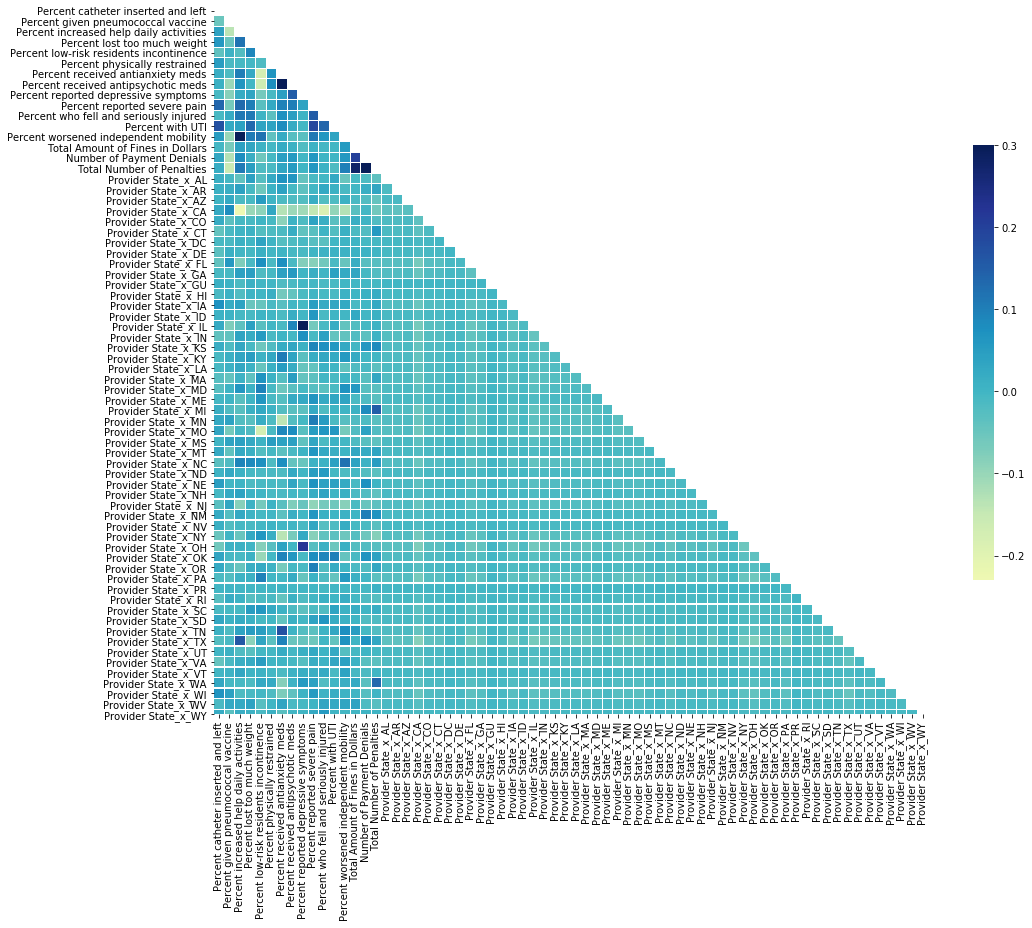

In [99]:
# We can look at the correlation plot using the heatmap() function from the seaborn package:
f, ax = plt.subplots(figsize=(16, 16))

# Generate a mask for the upper triangle
# np.zeros_like - Return an array of zeros with the same shape and type as a given array
# In this case we pass the correlation matrix
# we create a variable “mask” which is a 14 X 14 numpy array

mask = np.zeros_like(pearson, dtype=np.bool)
tt = np.triu_indices_from(mask)

# We create a tuple with triu_indices_from() by passing the “mask” array
# k is used to offset diagonal
# with k=0, we offset all diagnoals
# If we put k=13, means we offset 14-13=1 diagonal

# triu_indices_from() Return the indices for the upper-triangle of arr.
mask[np.triu_indices_from(mask, k=0)] = True

# First 2 param - anchor hues for negative and positive extents of the map.
# 3rd param - Anchor saturation for both extents of the map
# If true, return a matplotlib colormap object rather than a list of colors.

cmap = sns.diverging_palette(10, 129, s=50, as_cmap=True)

# Adjust size of the legend bar with cbar_kws={“shrink”: 0.5}
# cmap=“YlGnBu” gives the color from Yellow-Green-Blue palette

sns.heatmap(pearson, mask=mask, cmap="YlGnBu", vmax=.3, center=0,
           square=True, linewidths=.1, cbar_kws={"shrink": 0.5})

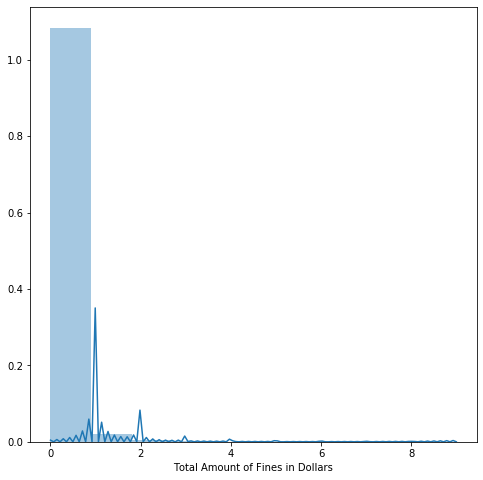

In [100]:
# We can look at the distribution of our target variable, Total Amount of Fines in Dollars, 
# using a histogram with a kernel density estimator as follows:

# Setting the plot size
plt.figure(figsize=(8, 8))

sns.distplot(df_quality_penalties_drop1['Total Amount of Fines in Dollars'], bins=10, kde=True)

C:\Users\tdrace\AppData\Local\Continuum\anaconda3\envs\main\lib\site-packages\seaborn\axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


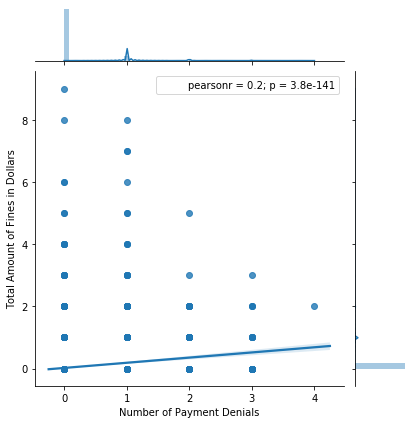

In [101]:
# We can also use JointGrid() from our seaborn package to plot a combination of plots:
from scipy import stats
g = sns.JointGrid(df_quality_penalties_drop1['Number of Payment Denials'], df_quality_penalties_drop1['Total Amount of Fines in Dollars'])
g = g.plot(sns.regplot, sns.distplot)
g = g.annotate(stats.pearsonr)

In [102]:
# We can create our training and testing datasets using the train_test_split class from sklearn.model_selection:

# Create feature and response variable set
# We create train & test sample from our dataset
from sklearn.model_selection import train_test_split

X = df_quality_penalties_drop1.drop('Total Amount of Fines in Dollars', axis=1)
Y = df_quality_penalties_drop1['Total Amount of Fines in Dollars']

# Create train & test sets
X_train, X_test, Y_train, Y_test = \
train_test_split(X, Y, test_size=0.30, random_state=1)

In [103]:
# We can now use SGDRegressor() to build a linear model. 
# We fit this linear model by minimizing the regularized empirical loss with SGD:

import numpy as np
from sklearn.linear_model import SGDRegressor

lin_model = SGDRegressor()

# We fit our model with train data
lin_model.fit(X_train, Y_train)

# We use predict() to predict our values
lin_model_predictions = lin_model.predict(X_test)

# We check the coefficient of determination with score()
print(lin_model.score(X_test, Y_test))

# We can also check the coefficient of determination with r2_score() from sklearn.metrics
from sklearn.metrics import r2_score
print(r2_score(Y_test, lin_model_predictions))

-8.56251943668953e+24
-8.56251943668953e+24


In [104]:
# We check the root mean square error (RMSE) on the test data:

from sklearn.metrics import mean_squared_error
mse = mean_squared_error(Y_test, lin_model_predictions)
rmse = np.sqrt(mse)
print(rmse)

693478632190.9261


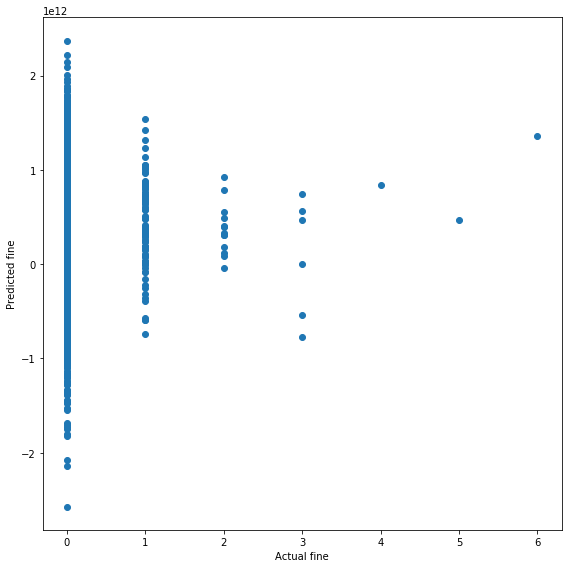

In [105]:
# We now plot the actual and predicted values using matplotlib.pyplot:

plt.figure(figsize=(8, 8))
plt.scatter(Y_test, lin_model_predictions)
plt.xlabel('Actual fine')
plt.ylabel('Predicted fine')
plt.tight_layout()

In [115]:
# so, obviously, this model doesn't fit

## Logistic Regression

Logistic regression is similar to linear regression, except that the dependent variable is measured on a dichotomous scale. 
Logistic regression allows us to model a relationship between multiple predictor variables and a dichotomous target variable. 

In [107]:
# import os for operating system dependent functionalities
import os

# import other required libraries
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
import matplotlib.pyplot as plt

In [108]:
# split features & response variable
X = df_quality_penalties_drop.drop('Fined?', axis=1)
Y = df_quality_penalties_drop['Fined?']

# Create train & test sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.30, random_state=1)

In [109]:
# We standardize our predictor variables using StandardScaler():
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [110]:
# We then move our model using SGDClassifier():
# We create an instance of SGDClassifier()
logistic_model = SGDClassifier(alpha=0.000001, loss='log', max_iter=100000, penalty='l2')

# We fit our model to the data
fitted_model = logistic_model.fit(X_train, Y_train)

# We use predict_proba() to predict the probabilities
predictedvalues = fitted_model.predict_proba(X_test)

# We print the probabilities to take a glance
predictedvalues

array([[0.00000000e+000, 1.00000000e+000],
       [1.00000000e+000, 6.21431375e-117],
       [1.00000000e+000, 3.03128932e-128],
       ...,
       [1.00000000e+000, 2.28365269e-069],
       [1.00000000e+000, 3.42868375e-084],
       [1.00000000e+000, 2.45842969e-102]])

In [111]:
# We separate out the probabilities of one class. In this case, we will look at class 1:
# We take the predicted values of class 1
Y_predicted = predictedvalues[:, 1]

# We check to see if the right values have been considered from the predicted values
print(Y_predicted)

[1.00000000e+000 6.21431375e-117 3.03128932e-128 ... 2.28365269e-069
 3.42868375e-084 2.45842969e-102]


In [112]:
# Check for accuracy
logistic_model.score(X_test,Y_test)

0.9997853616655935

In [113]:
# We can then see the area under curve (AUC) value of the receiver operating characteristic (ROC) curve:
# We use roc_curve() to generate fpr & tpr values
fpr, tpr, thresholds = roc_curve(Y_test, Y_predicted)

# we pass the fpr & tpr values to auc() to calculate the area under curve
roc_auc = auc(fpr, tpr)
roc_auc

1.0

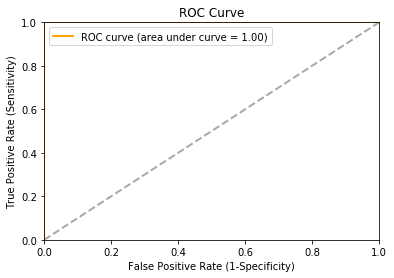

In [114]:
# We plot our ROC curve as follows:
plt.figure()
plt.plot(fpr,tpr, color='orange', lw=2, label='ROC curve (area under curve = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='darkgrey', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate (1-Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('ROC Curve')
plt.legend(loc='upper left')
plt.show()

In [ ]:
# alright, so 100% accuracy. Doesn't really tell us anything.

# Results

After our data wrangling, EDA, and feature engineering, we can see from our heatmap of all variables that really only the categories that are explicitly related to penalties are predictive of whether or not a SNF received a fine. This tells us that fines and payment denials go hand in hand and suggests that factors outside of quality of life meaurements are much more strongly predictive of fines. We can also see in our heatmap that certain states have slightly more predictive power than others, but the correlations are small. These obsevrations seem to be confirmed by our histograms of nursing homes which were fined versus those which were not fined.

It seems that we could stop there, but we want more verification and we want to run more tests. Our Max Voting algorithm returned 100% accuracy for Decision Tree and Logistic Regression classifiers, which we would expect given that we included all data and we know from prior analysis only some of them are predictive but those that are predictive are strongly so. The Max Voting algorithm also returns 76% accuracy for the SVC algorithm which is strange. We also employed averaging and weighted averaging, which returned numpy arrays for each observation that we could take the next step and incorprate back into our dataframe, but that was not our purpose here. We employed k-fold CV which returned a graph suggesting weak predictive power since a reported fine of 8 was predicted to have a value between 0 and 0.3, on a scale of 9 which we chose as our largest bucket for fine amount. We employed bootstrapping and multiple linear regression; the MLR algorithm in particular showed us that payment denials are positive correlated with total amount of fines, but had negative predictive accuracy beyond that. We finally employed a logistic regression algorithm which returned 100% accuracy, which we already knew from our Max Voting test. 

# Discussion

It is clear that quality of life measurements of long-term nursing home residents are not predictive of whether or not a SNF recieves a fine, as well as how much. There could be a number of reasons for this. 

First and foremost, nursing homes are not traditionally used as places for people to necessarily get better; more often than not, nursing home residents are there for the long-haul, and in our study here we were specifically dealing only with long-term residents. It is likely that the residents for whom measurements were taken are there a priori due to the very ailments which were measured in the first place. This is not surprising, but we possibly uncovered empirical evidence of such here. 

Second, because some variables were much more strongly correlated than others, we had to do some jerryrigging of our data from time to time just to see if the models would return different values; sometimes they did, sometimes they didn't. In another context, we may want to automate feature selection and engineering such that only the best features are included. There was another dimension meant to be included with this project, data on SNF ownership and composition, but time did not allow for completion of that project, which projected to be a much longer affair than the one presented here. Given time constraints and practicality, those elements were not included, but could be in a future project. It could be illustrative having more variables for which correlation can be measured. 

Finally, some of our testing was redundant. We could see early on that many of our features were not correlative, and those which were correlative were obviously-so given common sense relationship to fine frequency and fine amount. Nonetheless, we got some experience running them and learning about how they work for future projects.

# Acknowledgments

Many thanks to Stackoverflow, my employer, and my classmates for their skills, knowledge, and geneorsity.

# References

Burack, O. R., Weiner, A. S., Reinhardt, J. P., & Annunziato, R. A. (2012). What Matters Most to Nursing Home Elders: Quality of Life in the Nursing Home. Journal of the American Medical Directors Association, 13(1), 48–53. https://doi.org/10.1016/j.jamda.2010.08.002

Casari, A., & Zheng, A. (2018). Feature Engineering for Machine Learning. Retrieved from https://learning.oreilly.com/library/view/feature-engineering-for/9781491953235/

Castle, N. G. (2008). Nursing Home Caregiver Staffing Levels and Quality of Care: A Literature Review. Journal of Applied Gerontology, 27(4), 375–405. https://doi.org/10.1177/0733464808321596

Harrington, C., Woolhandler, S., Mullan, J., Carrillo, H., & Himmelstein, D. U. (2001). Does Investor Ownership of Nursing Homes Compromise the Quality of Care? American Journal of Public Health, 91(9), 1452–1455. https://doi.org/10.2105/AJPH.91.9.1452

Intrator, O., Zinn, J., & Mor, V. (2004). Nursing Home Characteristics and Potentially Preventable Hospitalizations of Long-Stay Residents. Journal of the American Geriatrics Society, 52(10), 1730–1736. https://doi.org/10.1111/j.1532-5415.2004.52469.x

McKinney, W. (2017). Python for Data Analysis, 2nd Edition. Retrieved from https://learning.oreilly.com/library/view/python-for-data/9781491957653/

Sullivan‐Marx, E. M., Strumpf, N. E., Evans, L. K., Baumgarten, M., & Maislin, G. (1999). Predictors of Continued Physical Restraint Use in Nursing Home Residents Following Restraint Reduction Efforts. Journal of the American Geriatrics Society, 47(3), 342–348. https://doi.org/10.1111/j.1532-5415.1999.tb02999.x

Vijayalakshmi, N., & Sarkar, D. (2019). Ensemble Machine Learning Cookbook. Retrieved from https://learning.oreilly.com/library/view/ensemble-machine-learning/9781789136609/